<a href="https://colab.research.google.com/github/KutapiAise/LearnTensorflow/blob/master/tf_flowersTransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
tf.enable_eager_execution()

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [0]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [3]:
splits = tfds.Split.TRAIN.subsplit([70, 30])

(training_set, validation_set), dataset_info = tfds.load('tf_flowers', with_info=True, as_supervised=True, split=splits)

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/1.0.0. Subsequent calls will reuse this data.


In [4]:
num_classes = dataset_info.features['label'].num_classes

num_training_examples = 0
num_validation_examples = 0

for example in training_set:
  num_training_examples += 1

for example in validation_set:
  num_validation_examples += 1

print('Total Number of Classes: {}'.format(num_classes))
print('Total Number of Training Images: {}'.format(num_training_examples))
print('Total Number of Validation Images: {} \n'.format(num_validation_examples))

Total Number of Classes: 5
Total Number of Training Images: 2590
Total Number of Validation Images: 1080 



In [5]:
for i, example in enumerate(training_set.take(5)):
  print('Image {} shape: {} label: {}'.format(i+1, example[0].shape, example[1]))

Image 1 shape: (240, 185, 3) label: 1
Image 2 shape: (333, 500, 3) label: 4
Image 3 shape: (213, 320, 3) label: 4
Image 4 shape: (239, 320, 3) label: 1
Image 5 shape: (256, 320, 3) label: 4


In [0]:
IMAGE_RES = 224

def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label




In [0]:
IMAGE_RES = 299

BATCH_SIZE = 32

(training_set, validation_set), dataset_info = tfds.load('tf_flowers', with_info=True, as_supervised=True, split=splits)
train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)



In [8]:
URL = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
  input_shape=(IMAGE_RES, IMAGE_RES, 3),
  trainable=False)

model_inception = tf.keras.Sequential([
  feature_extractor,
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

model_inception.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              21802784  
_________________________________________________________________
dense (Dense)                (None, 5)                 10245     
Total params: 21,813,029
Trainable params: 10,245
Non-trainable params: 21,802,784
_________________________________________________________________


In [9]:
model_inception.compile(
  optimizer='adam', 
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'])

EPOCHS = 6

history = model_inception.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6
81/81 [==============================] - 47s 576ms/step - loss: 0.7272 - acc: 0.7452 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 2/6
81/81 [==============================] - 36s 438ms/step - loss: 0.3840 - acc: 0.8753 - val_loss: 0.4033 - val_acc: 0.8630
Epoch 3/6
81/81 [==============================] - 35s 436ms/step - loss: 0.3075 - acc: 0.8996 - val_loss: 0.3622 - val_acc: 0.8870
Epoch 4/6
81/81 [==============================] - 35s 438ms/step - loss: 0.2619 - acc: 0.9143 - val_loss: 0.3438 - val_acc: 0.8926
Epoch 5/6
81/81 [==============================] - 35s 438ms/step - loss: 0.2305 - acc: 0.9239 - val_loss: 0.3364 - val_acc: 0.8917
Epoch 6/6
81/81 [==============================] - 35s 437ms/step - loss: 0.2070 - acc: 0.9347 - val_loss: 0.3353 - val_acc: 0.8880


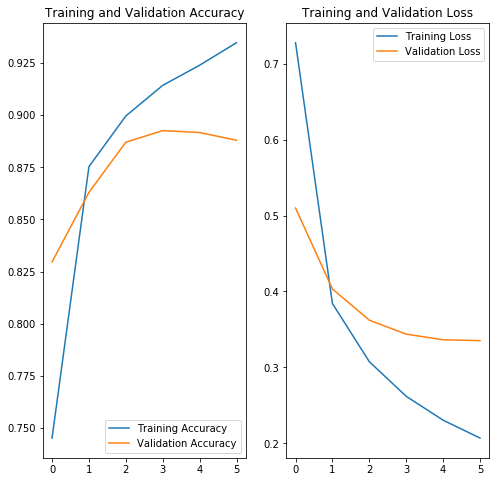

In [10]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [11]:
class_names = np.array(dataset_info.features['label'].names)

print(class_names)

['dandelion' 'daisy' 'tulips' 'sunflowers' 'roses']


In [13]:
image_batch, label_batch = next(iter(train_batches))


image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model_inception.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]

print(predicted_class_names)

['tulips' 'tulips' 'sunflowers' 'roses' 'tulips' 'tulips' 'roses' 'daisy'
 'roses' 'dandelion' 'tulips' 'daisy' 'tulips' 'roses' 'tulips'
 'dandelion' 'sunflowers' 'dandelion' 'daisy' 'daisy' 'dandelion' 'tulips'
 'sunflowers' 'sunflowers' 'sunflowers' 'dandelion' 'tulips' 'tulips'
 'daisy' 'sunflowers' 'dandelion' 'roses']


In [14]:
print("Labels:           ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:            [4 2 3 4 2 2 4 1 4 0 2 1 2 4 2 0 3 0 1 1 0 2 3 3 3 0 2 2 1 3 0 4]
Predicted labels:  [2 2 3 4 2 2 4 1 4 0 2 1 2 4 2 0 3 0 1 1 0 2 3 3 3 0 2 2 1 3 0 4]


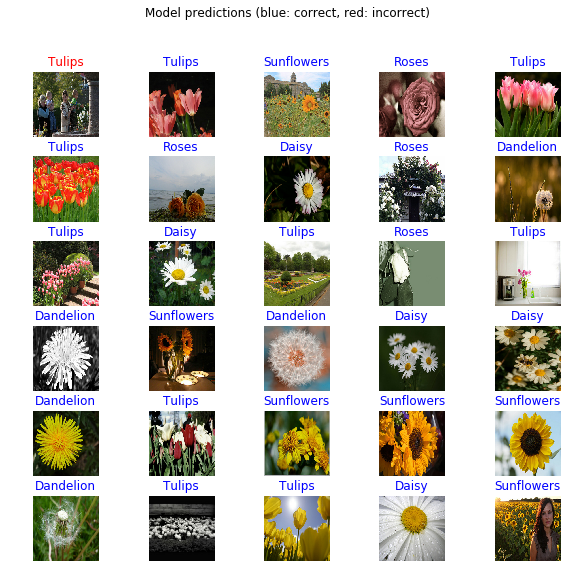

In [15]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")